In [1]:
import numpy as np

import pandas as pd 
import anndata as ad
import scanpy as sc

import screenpro as scp

import matplotlib.pyplot as plt

In [2]:
sc.settings.set_figure_params(dpi=150, frameon=False, figsize=(3, 3), color_map='RdGy', facecolor='white')

In [3]:
def ann_score_table(screen):
    
    hit_dict = {
        'gamma':{
            'up_hit':'up_hit', 
            'down_hit':'essential_hit'
        },
        'tau':{
            'up_hit':'up_hit', 
            'down_hit':'down_hit'
        },
        'rho':{
            'up_hit':'resistance_hit', 
            'down_hit':'sensitivity_hit'
        }
    }
    
    sel = ['target','score','ttest pvalue']# BH adj_pvalue # ttest pvalue
    scores = {score for score, col in screen.phenotypes['compare_reps'].columns}
    sort_var = screen.adata.var.sort_values(['targetType','target']).index.to_list()
    
    df_list = {}
    for score in scores:
        score_tag = score.split(':')[0]
        # get label
        df_label = scp.utils.ann_score_df(
            screen.phenotypes['compare_reps'][score].loc[:,sel],
            up_hit=hit_dict[score_tag]['up_hit'],
            down_hit=hit_dict[score_tag]['down_hit']
        )['label']
        # get replicate phe
        df_phe_reps = pdata[pdata.obs.score.eq(score_tag)].to_df().T
        
        # make table
        df = pd.concat([screen.phenotypes['compare_reps'][score], df_phe_reps, df_label],axis=1).loc[sort_var,:]
        
        df_list.update({score:df})
    
    out = pd.concat(df_list,axis=1)
    
    return out

### 

<!--     Total doubling:
    
    Vehicle		5.20
    NAC		5.56
    differences	-0.36 -->

In [4]:
meta = pd.read_excel('sample list.xlsx',index_col=0)
meta = pd.DataFrame(meta.reset_index()['Sample'].str.split(' |_').str[1:].to_list(),columns=['condition','replicate'],index=meta.Label.to_list())
meta.replicate = meta.replicate.str[-1].astype(int)

meta['pop_doublings'] = np.nan

meta.loc[(meta.condition == 'vehicle') & (meta.replicate == 1),'pop_doublings'] = 5.50
meta.loc[(meta.condition == 'NAC') & (meta.replicate == 1),'pop_doublings'] = 5.41

meta.loc[(meta.condition == 'vehicle') & (meta.replicate == 2),'pop_doublings'] = 5.50
meta.loc[(meta.condition == 'NAC') & (meta.replicate == 2),'pop_doublings'] = 5.60

meta.loc[(meta.condition == 'vehicle') & (meta.replicate == 3),'pop_doublings'] = 5.20
meta.loc[(meta.condition == 'NAC') & (meta.replicate == 3),'pop_doublings'] = 5.56

In [5]:
meta

,condition,replicate,pop_doublings
TO_1_S1,T0,1,NaN
TO_2_S2,T0,2,NaN
TO_3_S3,T0,3,NaN
TO_4_S4,vehicle,1,5.50
TO_5_S5,vehicle,2,5.50
TO_6_S6,vehicle,3,5.20
TO_7_S7,NAC,1,5.41
TO_8_S8,NAC,2,5.60
TO_9_S9,NAC,3,5.56


In [6]:
counts = pd.read_csv('NAC_counts.txt',sep='\t',index_col=0)

In [7]:
# pd.read_excel('NAC_screenmeasurements.xlsx',index_col=0,header=[0,1])

In [8]:
# library = pd.read_csv('CRISPRiV3_library_1_2_unbalanced.csv',index_col=0).set_index('sgID_AB')

target_df = counts[['target']].copy()
target_df['targetType'] = counts.target.apply(lambda x: "negCtrl" if x == "non-targeting" else "targeting")
target_df = target_df.sort_values('target').sort_values('targetType',ascending=False)
target_df.targetType = pd.Categorical(target_df.targetType,categories=['targeting','negCtrl'])

In [9]:
adata = ad.AnnData(
    X   = counts.loc[target_df.index,meta.index].T.astype(int),
    obs = meta,
    var = target_df
)

screen = scp.ScreenPro(adata)

In [10]:
adata.to_df().sum(axis=0).eq(0).sum()

0

In [11]:
screen.n_reps

3

In [12]:
help(screen.calculateDrugScreen)

Help on method calculateDrugScreen in module screenpro:

calculateDrugScreen(t0, untreated, treated, db_untreated, db_treated, score_level) method of screenpro.ScreenPro instance
    Calculate gamma, rho, and tau phenotype scores for a drug screen dataset in a given `score_level`
    see this issue for discussion https://github.com/abearab/ScreenPro2/issues/15.
    Args:
        t0 (str): name of the untreated condition
        untreated (str): name of the untreated condition
        treated (str): name of the treated condition
        db_untreated (float): doubling rate of the untreated condition
        db_treated (float): doubling rate of the treated condition
        score_level (str): name of the score level



In [13]:
screen.adata.obs

,condition,replicate,pop_doublings
TO_1_S1,T0,1,NaN
TO_2_S2,T0,2,NaN
TO_3_S3,T0,3,NaN
TO_4_S4,vehicle,1,5.50
TO_5_S5,vehicle,2,5.50
TO_6_S6,vehicle,3,5.20
TO_7_S7,NAC,1,5.41
TO_8_S8,NAC,2,5.60
TO_9_S9,NAC,3,5.56


In [14]:
scp.utils.find_low_counts(screen.adata)

24 variables with less than 50 reads in either replicates / experiment


In [15]:
screen.calculateDrugScreen(
    t0='T0', untreated='vehicle', treated='NAC', 
    db_untreated = 5.20,
    db_treated = 5.56,
    score_level='compare_reps'
)

	vehicle vs T0
	NAC vs T0
	NAC vs vehicle


### 

___
    
    Thu Nov 16 11:29:49 PST 2023
    
Tom 
> Are you able to extract phenotype scores from each screen replicate independently? The excel tables you provide are obviously an average of all replicates but I'd like to be able to plot bar graphs of phenotype scores for some genes that includes all three replicates to show the variability/error bars


#### replicate level scores

In [16]:
scp.utils.calculateGrowthFactor(screen, untreated = 'vehicle', treated = 'NAC', db_rate_col = 'pop_doublings')

,score,growth_factor,replicate
0,gamma,5.50,1
1,tau,5.41,1
2,rho,0.09,1
3,gamma,5.50,2
4,tau,5.60,2
5,rho,0.10,2
6,gamma,5.20,3
7,tau,5.56,3
8,rho,0.36,3


In [17]:
growth_factor_table = scp.utils.calculateGrowthFactor(
    screen, untreated = 'vehicle', 
    treated = 'NAC', db_rate_col = 'pop_doublings')

In [18]:
pdata = ad.AnnData(
    X=pd.concat([
        scp.ps.runPhenoScoreForReplicate(screen,'T0', 'vehicle','gamma',growth_factor_table).add_prefix('gamma_'),
        scp.ps.runPhenoScoreForReplicate(screen,'T0', 'NAC','tau',growth_factor_table).add_prefix('tau_'),
        scp.ps.runPhenoScoreForReplicate(screen,'vehicle', 'NAC','rho',growth_factor_table).add_prefix('rho_')
    ],axis=1).T,
    var=screen.adata.var
)

pdata.obs['score'] = pdata.obs.index.str.split('_').str[0]
pdata.obs['replicate'] = pdata.obs.index.str.split('_').str[2]

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:352: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)
/tmp/ipykernel_153963/4002916595.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


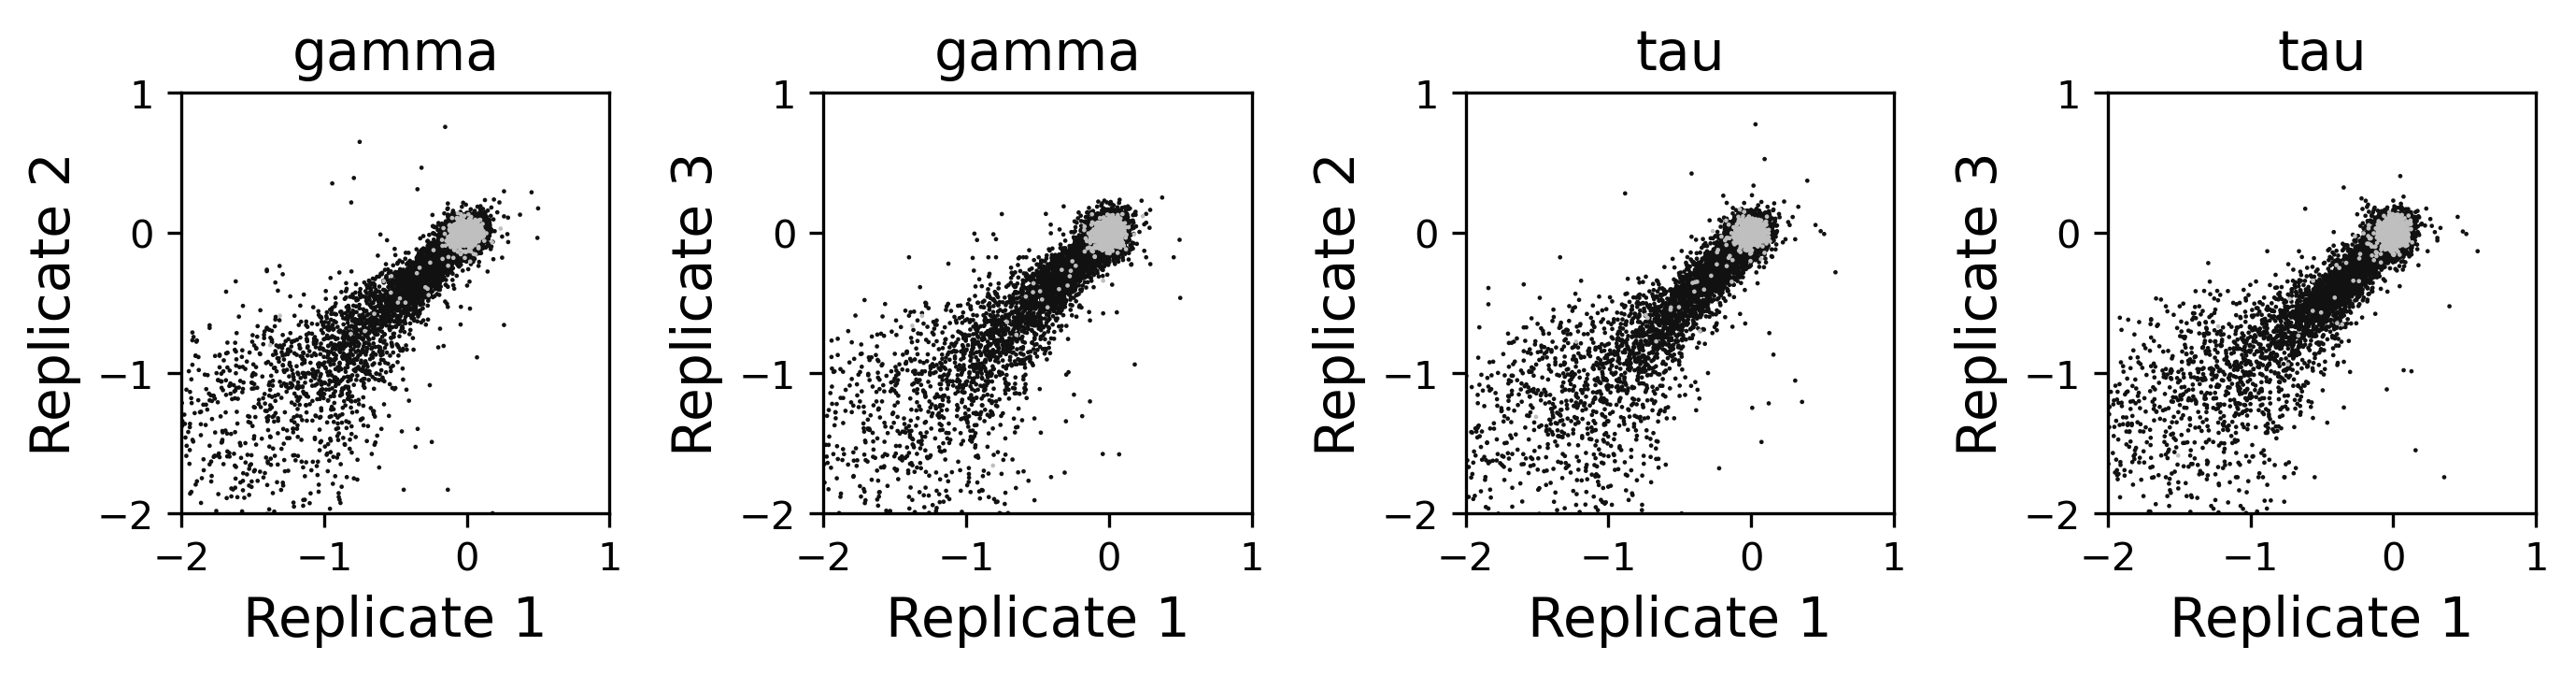

In [19]:
fig, axes = plt.subplots(ncols=4,
                         figsize=(10,3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.8,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], pdata, 'gamma_replicate_1','gamma_replicate_2','gamma',max_val=1)
scp.pl.plotReplicateScatter(axes[1], pdata, 'gamma_replicate_1','gamma_replicate_3','gamma',max_val=1)
scp.pl.plotReplicateScatter(axes[2], pdata, 'tau_replicate_1','tau_replicate_2','tau',max_val=1)
scp.pl.plotReplicateScatter(axes[3], pdata, 'tau_replicate_1','tau_replicate_3','tau',max_val=1)


plt.tight_layout()
plt.savefig('NAC_score_qc.pdf',bbox_inches='tight')
plt.show()

___

In [20]:
ann_score_table(screen).to_excel('results/NAC_screen.xlsx')

## Plots

In [21]:
from screenpro.plotting import almost_black, dark2

### replicate scatter plots

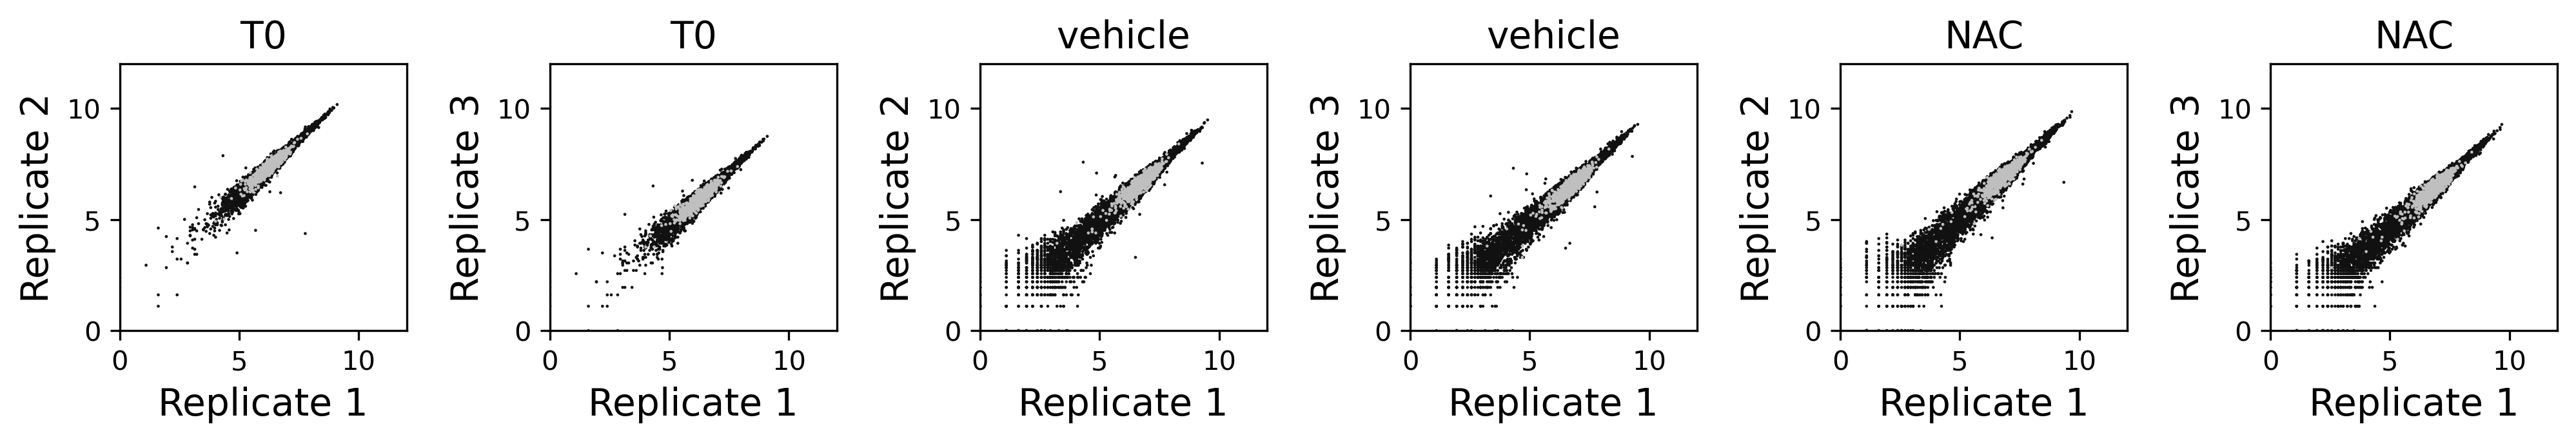

In [22]:
fig, axes = plt.subplots(ncols=6,
                         figsize=(15, 2.3), 
                         gridspec_kw={'wspace': 0.5, 'left': 0.12,'top':.9,'bottom':.3}, 
                         # sharey=True
                        )
scp.pl.plotReplicateScatter(axes[0], screen.adata, 'TO_1_S1','TO_2_S2','T0',min_val=0,max_val=12)
scp.pl.plotReplicateScatter(axes[1], screen.adata, 'TO_1_S1','TO_3_S3','T0',min_val=0,max_val=12)

scp.pl.plotReplicateScatter(axes[2], screen.adata, 'TO_4_S4','TO_5_S5','vehicle',min_val=0,max_val=12)
scp.pl.plotReplicateScatter(axes[3], screen.adata, 'TO_4_S4','TO_6_S6','vehicle',min_val=0,max_val=12)

scp.pl.plotReplicateScatter(axes[4], screen.adata, 'TO_7_S7','TO_8_S8','NAC',min_val=0,max_val=12)
scp.pl.plotReplicateScatter(axes[5], screen.adata, 'TO_7_S7','TO_9_S9','NAC',min_val=0,max_val=12)

plt.savefig('NAC_counts_qc.pdf',bbox_inches='tight')
plt.show()

### gamma

In [23]:
gamma = screen.phenotypes['compare_reps']['gamma:vehicle_vs_T0'].iloc[:,:3].reset_index(drop=True)

In [24]:
rho = screen.phenotypes['compare_reps']['rho:NAC_vs_vehicle'].iloc[:,:3].reset_index(drop=True)

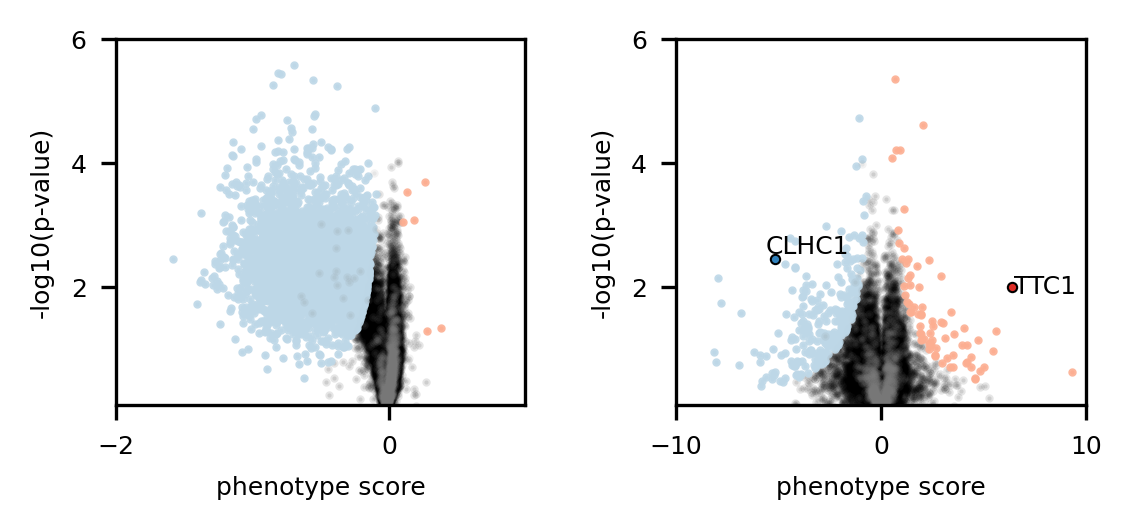

In [25]:
# Create subplots and specify the size
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(4, 2))

scp.pl.plot_volcano(ax1, gamma,threshold=5,xlim_l=-2, xlim_r=1)
ax1.grid(False)
ax1.get_legend().remove()

scp.pl.plot_volcano(ax2, rho,threshold=5,xlim_l=-10, xlim_r=10)
scp.pl.label_resistance_hit(ax2,rho,'TTC1',threshold=5,size=5,size_txt=6,t_x=.1)
scp.pl.label_sensitivity_hit(ax2,rho,'CLHC1',threshold=5,size=5,size_txt=6,t_y=.1)

ax2.grid(False)
ax2.get_legend().remove()

for ax in [ax1,ax2]:
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(6)

plt.tight_layout()
# Show the plot
plt.show()

In [26]:
# vol.save('NAC_rho_score.pdf')

# 

In [27]:
%reload_ext watermark

In [28]:
%watermark

Last updated: 2023-12-26T12:56:44.942594-08:00

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 3.10.0-957.27.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit



In [29]:
%watermark --iversions

anndata   : 0.9.1
scanpy    : 1.9.3
pandas    : 1.5.3
screenpro : 0.2.5
matplotlib: 3.7.2
numpy     : 1.24.4



In [30]:
!date

Tue Dec 26 12:56:45 PST 2023
